# <center> Übung Nr. 1 – 07.04.2022 </center>

## Aufgabe 1.1
Install PyTorch and get it to run.

Installation instructions: https://pytorch.org/get-started/locally/

### Solution

#### CUDA 11.8

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

#### CUDA 12.1 / Mac / Windows

In [ ]:
!pip3 install torch torchvision torchaudio

#### CPU

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

### Test the installation

In [1]:
import torch

[Optional] Check whether CUDA works properly

In [2]:
torch.cuda.is_available()

True

## Aufgabe 1.2

Realize this network using PyTorch

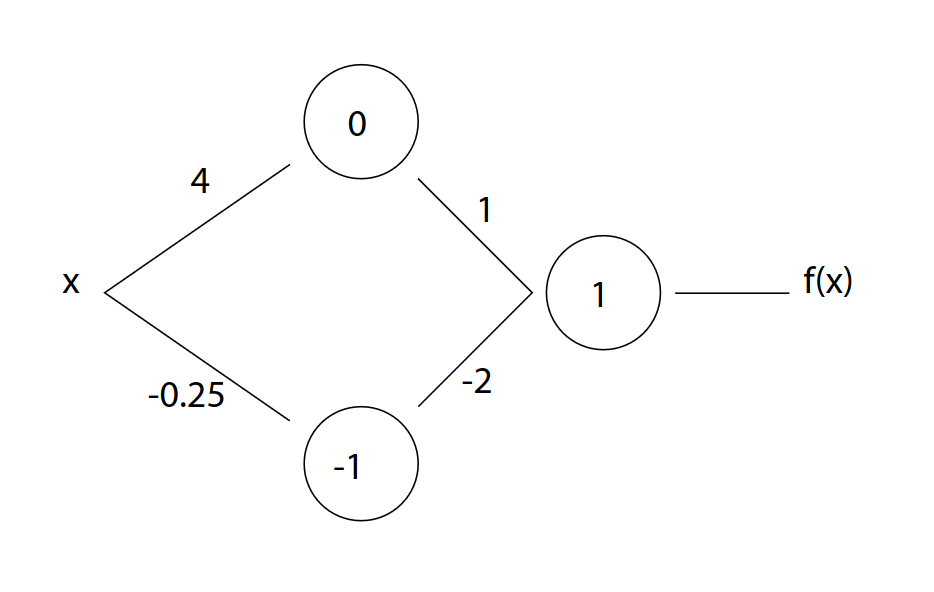

In [3]:
%matplotlib inline
from IPython.display import Image
Image(filename='example_network.png')

Numbers along the edges denote weights and numbers in the circle are bias values. The output layer
has no nonlinear activation function, i.e.

$$f(x) = \sigma(4x) - 2\sigma(-0.25*x-1)+1.$$

Visualize the function represented by the network for Sigmoid activation and for ReLU in the hidden
layer.

### Solution

In [4]:
import torch
import torch.nn as nn

#### Defining the activation function for the output layer

https://pytorch.org/docs/stable/generated/torch.nn.Module.html

Functional style

In [5]:
# functional style
def f(x):
    return torch.sigmoid(4*x) - 2*torch.sigmoid(-0.25 * x - 1) + 1

Using custom module (https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

In [6]:
class F(nn.Module):
    def forward(self, x):
        return torch.sigmoid(4*x) - 2*torch.sigmoid(-0.25 * x - 1) + 1

#### Defining the network

Using nn.Sequential (https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

Linear layer (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [7]:
network = nn.Sequential(
    nn.Linear(1, 2),
    nn.Sigmoid(),
    nn.Linear(2, 1),
    F()
)

Using custom module (https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

In [8]:
class Network(nn.Module):
    def __init__(self):
        # initialize nn.Module 
        super().__init__()
        
        self.layer1 = nn.Linear(1, 2)
        self.layer2 = nn.Linear(2, 1)

    def forward(self, x):
        y = self.layer1(x)
        y = torch.sigmoid(y)
        y = self.layer2(y)
        y = f(y)
        return y

        # or, alternatilely
        return f(self.layer2(torch.sigmoid(self.layer1)))

Alternatively

In [9]:
class Network(nn.Module):
    def __init__(self, activation_function):
        super().__init__()
        self.layer1 = nn.Linear(1, 2)
        self.activation_function = activation_function
        self.layer2 = nn.Linear(2, 1)

    def forward(self, x):
        y = self.layer1(x)
        y = self.activation_function(y)
        y = self.layer2(y)
        y = f(y)
        return y

In [10]:
network = Network(nn.ReLU)

#### Accessing and modifying the weights

Use torch.no_grad (https://pytorch.org/docs/stable/generated/torch.no_grad.html), since weights have requires_grad=True

In [11]:
def modify_weights(network):
    with torch.no_grad(): 
        network[0].weight[0,0] = 4
        network[0].weight[1,0] = -0.25
        network[0].bias[0] = 0
        network[0].bias[1] = -1

        network[2].weight[0,0] = 1
        network[2].weight[0,1] = -2
        network[2].bias[0] = 1

For the latter implementations we need to access the layers through network.layer1 and network.layer2 respectively

In [12]:
def modify_weights(network):
    with torch.no_grad(): 
        network.layer1.weight[0,0] = 4
        network.layer1.weight[1,0] = -0.25
        network.layer1.bias[0] = 0
        network.layer1.bias[1] = -1

        network.layer2.weight[0,0] = 1
        network.layer2.weight[0,1] = -2
        network.layer2.bias[0] = 1

#### Plotting the result

In [13]:
import matplotlib.pyplot as plt

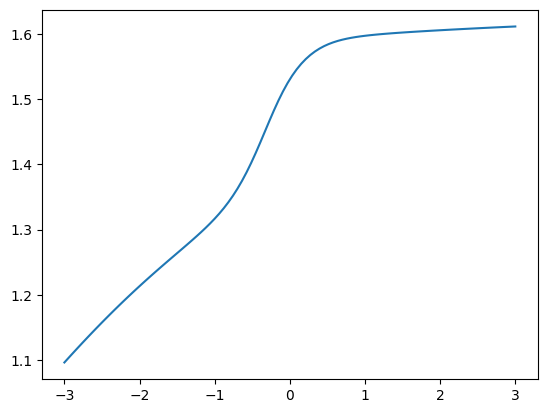

In [14]:
network = Network(nn.Sigmoid())
modify_weights(network)

x = torch.linspace(-3, 3, 100).reshape(-1, 1)
y = network(x)

# do not forget to detach the network output since it has grad_fn
plt.plot(x, y.detach()) 
# alternatively, you could use torch.no_grad for computating the network output to avoid this, see the cell below for example

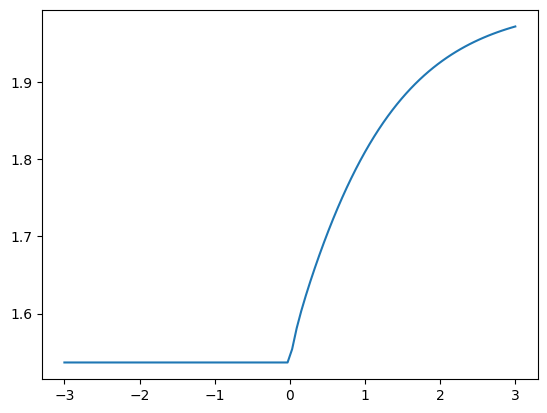

In [15]:
network = Network(nn.ReLU())
modify_weights(network)

x = torch.linspace(-3, 3, 100).reshape(-1, 1)

with torch.no_grad():
    y = network(x)
plt.plot(x, y)

## Aufgabe 1.3

We approximate the function

$$
f: [-2,2]^2 \rightarrow \mathbb{R}, \;\;\;\;\; f(x,y) = sin(x^2 + \frac{1}{2} x y^2)
$$
using a neural network f[P](x,y). Try to get the error
$$
\max\limits_{i,j=0,\dots,N_{\text{test}}} |f(x_i,y_i) - f[P](x_i, y_i)|
$$
as low using the $(1+N_{\text{train}})^2$ training points
$$
(x_i, y_j) = \Bigg(-2 + \frac{4i}{N_{\text{train}}}, -2 + \frac{4j}{N_{\text{train}}} \Bigg), \;\;\;\; i,j = 0,\dots,N_{\text{train}}
$$

<ol>
<li>First try to reach the accuracy in the training points, choosing different values for $N_{\text{train}}$.</li>
<li>Select separate (maybe random) testing points and try to reach the accuracy in these. Try to get
as good accuracy as possible. You’ll have to play around with the number of training and testing
points and with the layout of the network.</li>
</ol>

### Solution

#### Determining the device to run the code on

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Defining the function

In [17]:
def f(x, y):
    return torch.sin(x**2 + 0.5 * x * y**2)

#### Visualizing the function

In [18]:
N_train = 100
xs = ys = torch.linspace(-2, 2, N_train)
X, Y = torch.meshgrid(xs, ys, indexing='xy')
Z = f(X, Y)

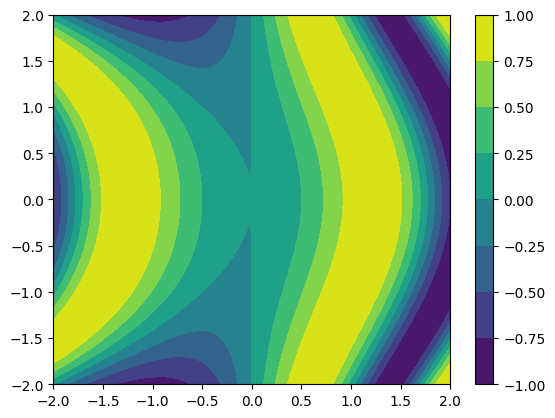

In [19]:
plt.contourf(X, Y, Z)
plt.colorbar()

#### Preparing the data

Datasets & DataLoaders tutorial - https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

DataLoader - https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

TensorDataset - https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset

In [20]:
inputs = torch.column_stack((X.flatten(), Y.flatten())).to(device)
target = Z.reshape(-1, 1).to(device) # it's important that target is two dimensional!
dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(inputs, target), batch_size=512, shuffle=True)

#### Defining the network

In [21]:
activation_function = nn.GELU()
num_neurons = 128
network = nn.Sequential(
    nn.Linear(2, num_neurons),
    activation_function,
    nn.Linear(num_neurons, num_neurons),
    activation_function,
    nn.Linear(num_neurons, num_neurons),
    activation_function,
    nn.Linear(num_neurons, num_neurons),
    activation_function,
    nn.Linear(num_neurons, num_neurons),
    activation_function,
    nn.Linear(num_neurons, 1),
).to(device)

#### Defining the loss and the optimization algorithm

List of loss functions - https://pytorch.org/docs/stable/nn.html#loss-functions

List of optimizers - https://pytorch.org/docs/stable/optim.html#algorithms

Learning rate schedulers - https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [22]:
import torch.optim as optim

loss_fn = nn.L1Loss()
optimizer = optim.Adam(network.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 400, 900], gamma=0.1)

#### Training loop

In [23]:
epochs = 1000
loss_history = []
for i in range(epochs):
    running_loss = 0
    for x, y in dataloader:
        pred = network(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    loss_history.append(running_loss / len(dataloader))

#### Visualize the loss function

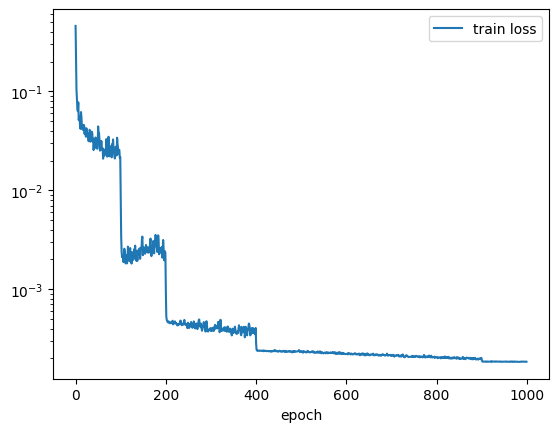

In [24]:
plt.plot(loss_history, label='train loss')
plt.yscale('log')
plt.gca().set_xlabel('epoch')
plt.legend()

#### Visualize the network prediction

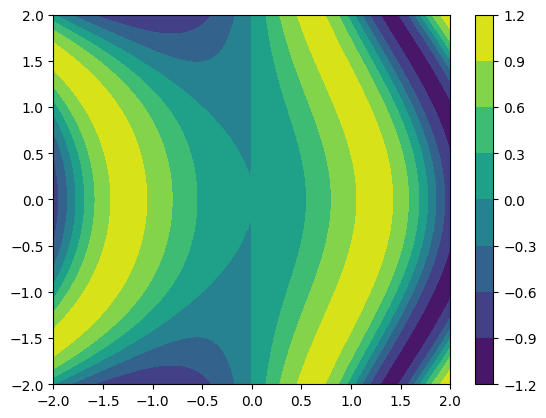

In [25]:
Z_pred = network(inputs).reshape(*X.shape).detach().cpu()
plt.contourf(X, Y, Z_pred)
plt.colorbar()

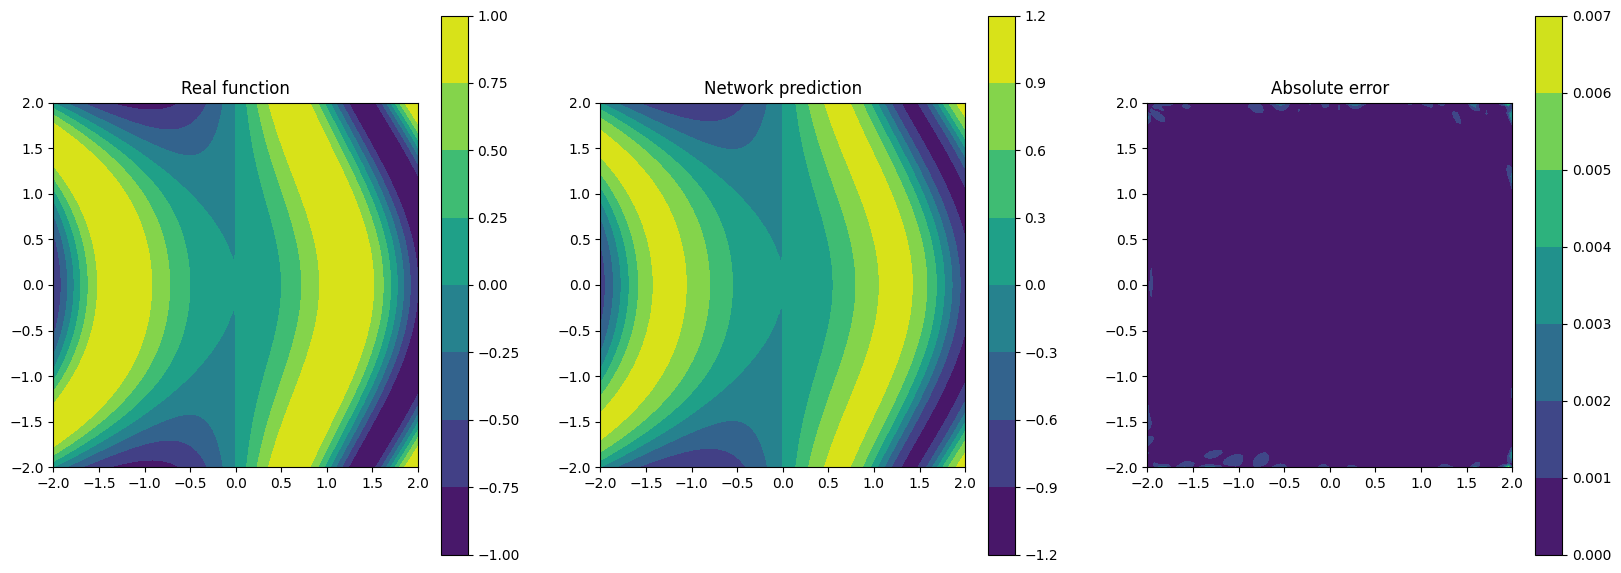

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

im0 = axs[0].contourf(X, Y, Z)
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Real function")
axs[0].set_aspect('equal')

im1 = axs[1].contourf(X, Y, Z_pred)
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Network prediction")
axs[1].set_aspect('equal')

im2 = axs[2].contourf(X, Y, torch.abs(Z_pred - Z))
fig.colorbar(im2, ax=axs[2])
axs[2].set_title("Absolute error")
axs[2].set_aspect('equal')

#### Compute the validation metrics

In [27]:
torch.mean(torch.abs(Z - Z_pred))

tensor(0.0002)

In [28]:
torch.max(torch.abs(Z - Z_pred))

tensor(0.0069)

## Things to try
- implement keeping track of the validation metrics during the training (maximum and mean absolute errors)
- pick the data for the test dataset and explain your choice
- implement keeping track of the loss and validation metrics on the test dataset during the training
- visualize the loss and the metrics

- play with the hyperparameters
  - dataset size
  - numbers of neurons in hidden layers, e.g. gradually decreasing them towards the end of the network
  - residual connections
  - loss functions
  - activation functions (maybe some exotic ones, e.g. Snake from https://arxiv.org/pdf/2006.08195.pdf)
  - optimizers and their parameters
  - batch size
  - learning rate and schedulers

## Links

pytorch installation instructions - https://pytorch.org/get-started/locally/

pytorch documentation - https://pytorch.org/docs/stable/index.html

activation functions - https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

Loss functions - https://pytorch.org/docs/stable/nn.html#loss-functions

Optimizers - https://pytorch.org/docs/stable/optim.html#algorithms

LR Schedulers - https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

DataLoaders & Datasets - https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

DataLoader - https://pytorch.org/docs/stable/generated/torch.no_grad.html

TensorDataset - https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset

Learning PyTorch with Examples - https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Custom nn Modules - https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html

The Deep Learning textbook - https://www.deeplearningbook.org/

## Other suggestions

### tqdm 

https://github.com/tqdm/tqdm

#### Installation

In [ ]:
!pip install tqdm

#### Basic usage

In [30]:
from tqdm.auto import trange

for _ in trange(10000000):
    pass

/home/ukapusts@ads.uni-magdeburg.de/.pyenv/versions/3.12.2/envs/work-3.12.2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 10000000/10000000 [00:03<00:00, 2831221.29it/s]


#### Displaying additional data

In [31]:
with trange(3000) as t:
    for i in t:
        t.set_postfix(loss = i**0.5)

100%|██████████| 3000/3000 [00:05<00:00, 598.01it/s, loss=54.8]


### Weights & Biases

https://github.com/wandb/wandb

#### Quickstart

Get started with W&B in four steps:

1. First, sign up for a [free W&B account](https://wandb.ai/login?utm_source=github&utm_medium=code&utm_campaign=wandb&utm_content=quickstart).

2. Second, install the W&B SDK with [pip](https://pip.pypa.io/en/stable/). Navigate to your terminal and type the following command:

```bash
pip install wandb
```

3. Third, log into W&B:

```python
wandb.login()
```

4. Use the example code snippet below as a template to integrate W&B to your Python script:

```python
import wandb

# Start a W&B Run with wandb.init
run = wandb.init(project="my_first_project")

# Save model inputs and hyperparameters in a wandb.config object
config = run.config
config.learning_rate = 0.01

# Model training code here ...

# Log metrics over time to visualize performance with wandb.log
for i in range(10):
    run.log({"loss": loss})
```

That's it! Navigate to the W&B App to view a dashboard of your first W&B Experiment. Use the W&B App to compare multiple experiments in a unified place, dive into the results of a single run, and much more!

<p align='center'>
<img src="./imgs/wandb_demo_experiments.gif" width="100%">
</p>
<p align = "center">
Example W&B Dashboard that shows Runs from an Experiment.
</p>

&nbsp;